# TEXT ENCODING

# WHOLE PRETRAINED MODEL LOADED

https://huggingface.co/transformers/model_doc/bert.html#bertmodel

12 Layers

In [1]:
from transformers import BertTokenizer, BertModel
import torch
from torch import nn as nn
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
input_text = "A horse in front of a fire"
inputs = tokenizer(input_text, return_tensors="pt")
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state
print(last_hidden_states)
print(last_hidden_states.size())

tensor([[[-0.2996, -0.1209, -0.6825,  ..., -0.4434,  0.0933, -0.0246],
         [ 0.2336,  0.1665, -0.6575,  ..., -0.6481,  0.1725, -0.1876],
         [ 0.7200, -0.2236,  0.3367,  ..., -1.1235, -0.0043,  0.1682],
         ...,
         [-0.1362, -0.2959, -0.2683,  ..., -0.3698, -0.0348, -0.2035],
         [ 0.2963,  0.0361, -0.3257,  ..., -0.1107, -0.1278, -0.5886],
         [ 0.5249, -0.0250, -0.5015,  ..., -0.0803, -0.6622, -0.2311]]],
       grad_fn=<NativeLayerNormBackward>)
torch.Size([1, 9, 768])


# PAPER PRETRAINED IMPLEMENTATION

https://github.com/mesnico/TERN

6 Layers

In [2]:
import torch
from torch import nn as nn
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from transformers import BertTokenizer, BertModel, BertConfig


def EncoderText(config):
    num_layers = config['text-model']['layers']
    order_embeddings = config['training']['measure'] == 'order'
    if config['text-model']['name'] == 'bert':
        print('Using BERT text encoder')
        model = EncoderTextBERT(config, order_embeddings=order_embeddings, post_transformer_layers=num_layers)
    else:
        model = None
    return model


class EncoderTextBERT(nn.Module):
    def __init__(self, config, order_embeddings=False, mean=True, post_transformer_layers=0):
        super().__init__()
        self.preextracted = config['text-model']['pre-extracted']
        bert_config = BertConfig.from_pretrained(config['text-model']['pretrain'],
                                                 output_hidden_states=True,
                                                 num_hidden_layers=config['text-model']['extraction-hidden-layer'])
        bert_model = BertModel.from_pretrained(config['text-model']['pretrain'], config=bert_config)
        self.order_embeddings = order_embeddings
        self.vocab_size = bert_model.config.vocab_size
        self.hidden_layer = config['text-model']['extraction-hidden-layer']
        if not self.preextracted:
            self.tokenizer = BertTokenizer.from_pretrained(config['text-model']['pretrain'])
            self.bert_model = bert_model
            self.word_embeddings = self.bert_model.get_input_embeddings()
        if post_transformer_layers > 0:
            transformer_layer = nn.TransformerEncoderLayer(d_model=config['text-model']['word-dim'], nhead=4,
                                                           dim_feedforward=2048,
                                                           dropout=config['text-model']['dropout'], activation='relu')
            self.transformer_encoder = nn.TransformerEncoder(transformer_layer,
                                                             num_layers=post_transformer_layers)
        self.post_transformer_layers = post_transformer_layers
        self.map = nn.Linear(config['text-model']['word-dim'], config['model']['embed-size'])
        self.mean = mean

    def forward(self, x, max_len, attention_mask=None):
        
        '''
        x: tensor of indexes (LongTensor) obtained with tokenizer.encode() of size B x ?
        lengths: tensor of lengths (LongTensor) of size B
        '''
        '''
        if not self.preextracted or self.post_transformer_layers > 0:
            
            
            attention_mask = torch.ones(x.shape[0], max_len)
            
            print(zip(attention_mask, max_len))
            for e,l in zip(attention_mask, max_len):
                e[l:] = 0
            attention_mask = attention_mask.to(x.device)
            '''



        if self.preextracted:
            outputs = x
        if attention_mask:
            outputs = self.bert_model(x, attention_mask=attention_mask)
            outputs = outputs[2][-1]
        else:
            outputs = self.bert_model(x)
            outputs = outputs[2][-1]

        if self.post_transformer_layers > 0:
            outputs = outputs.permute(1, 0, 2)
            outputs = self.transformer_encoder(outputs, src_key_padding_mask=(attention_mask - 1).bool())
            outputs = outputs.permute(1, 0, 2)
        if self.mean:
            x = outputs.mean(dim=1)
        else:
            x = outputs[:, 0, :]     # from the last layer take only the first word

        out = self.map(x)

        # normalization in the joint embedding space
        # out = l2norm(out)

        # take absolute value, used by order embeddings
        if self.order_embeddings:
            out = torch.abs(out)
        return out, outputs

    def get_finetuning_params(self):
        return list(self.bert_model.parameters())

In [3]:
import yaml
with open("Configurations/config.yaml", 'r') as ymlfile:
        config = yaml.load(ymlfile, Loader=yaml.FullLoader)

In [4]:
text_encoder = EncoderText(config)

Using BERT text encoder


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['bert.encoder.layer.6.attention.self.query.weight', 'bert.encoder.layer.6.attention.self.query.bias', 'bert.encoder.layer.6.attention.self.key.weight', 'bert.encoder.layer.6.attention.self.key.bias', 'bert.encoder.layer.6.attention.self.value.weight', 'bert.encoder.layer.6.attention.self.value.bias', 'bert.encoder.layer.6.attention.output.dense.weight', 'bert.encoder.layer.6.attention.output.dense.bias', 'bert.encoder.layer.6.intermediate.dense.weight', 'bert.encoder.layer.6.intermediate.dense.bias', 'bert.encoder.layer.6.output.dense.weight', 'bert.encoder.layer.6.output.dense.bias', 'bert.encoder.layer.7.attention.self.query.weight', 'bert.encoder.layer.7.attention.self.query.bias', 'bert.encoder.layer.7.attention.self.key.weight', 'bert.encoder.layer.7.attention.self.key.bias', 'bert.encoder.layer.7.attention.self.value.weight', 'bert.encoder.layer.7.attention.self.value.bias', 'ber

In [5]:
text = "Hello, my dog is cute"

tokenizer = BertTokenizer.from_pretrained(config['text-model']['pretrain'])

input = tokenizer(text)

input.keys()

input_ids = input.get("input_ids")
token_type_ids = input.get("token_type_ids")
attention_mask = input.get("attention_mask")

input_ids = torch.as_tensor(input_ids)
attention_mask = torch.as_tensor(attention_mask)

output = text_encoder(input_ids.unsqueeze(0), len(input_ids))[1]

print(output)
print(output.size())

tensor([[[ 0.0670, -0.7915, -0.4175,  ..., -0.0122,  0.4668,  0.3089],
         [ 0.5813, -0.3311,  1.0195,  ...,  0.8119,  0.3096, -0.8040],
         [-0.0136,  0.8276,  0.0538,  ..., -0.1876,  0.3317,  0.3393],
         ...,
         [ 0.3413, -0.6024,  0.1903,  ..., -0.0860, -0.0326,  0.6743],
         [-0.7663,  0.3095,  0.3220,  ..., -0.3727, -0.1407, -1.0038],
         [ 0.0171, -0.0395, -0.0047,  ...,  0.0102, -0.0125, -0.0415]]],
       grad_fn=<NativeLayerNormBackward>)
torch.Size([1, 8, 768])


# IMAGE ENCODING

In [6]:
from collections import OrderedDict

import numpy as np
import torch
from torch import nn as nn
from torchvision import models as models

class PositionalEncodingImageBoxes(nn.Module):
    def __init__(self, d_model, mode='project-and-sum'):
        super().__init__()
        self.mode = mode
        if mode == 'project-and-sum':
            self.map = nn.Linear(5, d_model)
        elif mode == 'concat-and-process':
            self.map = nn.Sequential(
                nn.Linear(d_model + 5, d_model),
                nn.ReLU(),
                nn.Linear(d_model, d_model)
            )
            
    def forward(self, x, boxes):  # x is seq_len x B x dim
        bs = x.shape[1]
        area = (boxes[:, :, 2] - boxes[:, :, 0]) * (boxes[:, :, 3] - boxes[:, :, 1])
        area = area.unsqueeze(2)
        s_infos = torch.cat([boxes, area], dim=2)
        if self.mode == 'project-and-sum':
            ct = self.map(s_infos).permute(1, 0, 2)    # S x B x dim
            x = x + ct.expand(-1, bs, -1)
        elif self.mode == 'concat-and-process':
            x = torch.cat([x, s_infos.permute(1, 0, 2)], dim=2)
            x = self.map(x)
        return x

def EncoderImage(config):

    # data_name, img_dim, embed_size, finetune=False,
    #         cnn_type='vgg19', use_abs=False, no_imgnorm=False):
    """A wrapper to image encoders. Chooses between an encoder that uses
    precomputed image features, `EncoderImagePrecomp`, or an encoder that
    computes image features on the fly `EncoderImageFull`.
    """

    embed_size = config['model']['embed-size']
    order_embeddings = config['training']['measure'] == 'order'
    if config['image-model']['name'] == 'bottomup':
        transformer_layers = config['image-model']['transformer-layers']
        pos_encoding = config['image-model']['pos-encoding']
        visual_feat_dim = config['image-model']['feat-dim']
        dropout = config['image-model']['dropout']
        img_enc = TransformerPostProcessing(transformer_layers, visual_feat_dim, embed_size, n_head=4, aggr='mean', pos_encoding=pos_encoding, dropout=dropout, order_embeddings=order_embeddings)
    else:
        img_enc = None

    return img_enc


class TransformerPostProcessing(nn.Module):
    def __init__(self, num_transformer_layers, feat_dim, embed_size, n_head=4, aggr='mean', pos_encoding=None, dropout=0.1, order_embeddings=False):
        super().__init__()
        
        transformer_layer = nn.TransformerEncoderLayer(d_model=feat_dim, nhead=n_head,
                                                       dim_feedforward=2048,
                                                       dropout=dropout, activation='relu')
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer,
                                                         num_layers=num_transformer_layers)
        if pos_encoding is not None:
            self.pos_encoding_image = PositionalEncodingImageBoxes(feat_dim, pos_encoding)
        self.fc = nn.Linear(feat_dim, embed_size)
        self.aggr = aggr
        self.order_embeddings = order_embeddings
        if aggr == 'gated':
            self.gate_fn = nn.Sequential(
                nn.Linear(feat_dim, feat_dim),
                nn.ReLU(),
                nn.Linear(feat_dim, 1)
            )
            self.node_fn = nn.Sequential(
                nn.Linear(feat_dim, feat_dim),
                nn.ReLU(),
                nn.Linear(feat_dim, feat_dim)
            )
        self.pos_encoding = pos_encoding

    def forward(self, visual_feats, visual_feats_len=None, boxes=None):
        """
        Takes an variable len batch of visual features and preprocess them through a transformer. Output a tensor
        with the same shape as visual_feats passed in input.
        :param visual_feats:
        :param visual_feats_len:
        :return: a tensor with the same shape as visual_feats passed in input.
        """
        # max_len = max(visual_feats_len)
        # bs = visual_feats.shape[1]
        # attention_mask = torch.zeros(bs, max_len).bool()
        # for e, l in zip(attention_mask, visual_feats_len):
        #     e[l:] = True
        # attention_mask = attention_mask.to(visual_feats.device)

        visual_feats = visual_feats.permute(1, 0, 2)
        if self.pos_encoding is not None:
            visual_feats = self.pos_encoding_image(visual_feats, boxes)

        if visual_feats_len is not None:
            bs = visual_feats.shape[1]
            # construct the attention mask
            max_len = max(visual_feats_len)
            mask = torch.zeros(bs, max_len).bool()
            for e, l in zip(mask, visual_feats_len):
                e[l:] = True
            mask = mask.to(visual_feats.device)
        else:
            mask = None

        visual_feats = self.transformer_encoder(visual_feats, src_key_padding_mask=mask)
        # visual_feats = visual_feats.permute(1, 0, 2)

        if self.aggr == 'mean':
            out = visual_feats.mean(dim=0)
        elif self.aggr == 'gated':
            out = visual_feats.permute(1, 0, 2)
            m = torch.sigmoid(self.gate_fn(out))   # B x S x 1
            v = self.node_fn(out)   # B x S x dim
            out = torch.bmm(m.permute(0, 2, 1), v)      # B x 1 x dim
            out = out.squeeze(1)    # B x dim
        else:
            out = visual_feats[0]

        out = self.fc(out)
        if self.order_embeddings:
            out = torch.abs(out)

        return out, visual_feats.permute(1, 0, 2)


def find_nhead(feat_dim, higher=8):
    # find the right n_head value (the highest value lower than 'higher')
    for i in reversed(range(higher + 1)):
        if feat_dim % i == 0:
            return i
    return 1

In [7]:
img_encoder = EncoderImage(config)

In [8]:
n_head = find_nhead(500)
transformer_layer = nn.TransformerEncoderLayer(d_model=500, nhead=n_head,
                                               dim_feedforward=2048,
                                               dropout=0.1, activation='relu')
transformer_encoder = nn.TransformerEncoder(transformer_layer,
                                                 num_layers=4)

In [9]:
def dot_sim(im, s):
    """Cosine similarity between all the image and sentence pairs
    """
    return im.mm(s.t())

def order_sim(im, s):
    """Order embeddings similarity measure $max(0, s-im)$
    
    YmX = (s.expand(s.size(0), im.size(0), s.size(1))
           - im.unsqueeze(0).expand(s.size(0), im.size(0), s.size(1)))
    score = -YmX.clamp(min=0).pow(2).sum(2).sqrt().t()
    """
    score = (s.expand(s.size(0), im.size(0), s.size(1))
           - im.unsqueeze(0).expand(s.size(0), im.size(0), s.size(1)))
    return score.squeeze(0)

C:\Users\rubio\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  


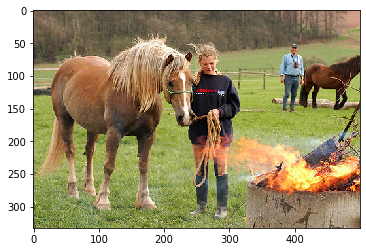

Description: A horse in front of a fire


In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

# Showing inputs
img_original =plt.imread("E://TFM/Flickr8k/Images/10815824_2997e03d76.jpg")
img = torch.as_tensor(img_original)

plt.imshow(img)
plt.show()

print("Description: " + input_text)

# Image encoding
img = img.permute(2, 0, 1)
img = img.type(torch.FloatTensor)
out = transformer_encoder(img)
fc = nn.Linear(500, 1024)
out = fc(out)
img_emb = out.mean(dim=0)
# out = out.permute(2, 1, 0)
# print(out.size())
# print(img_emb.size())


map = nn.Linear(config['text-model']['word-dim'], config['model']['embed-size'])
x = last_hidden_states.mean(dim=1)
text_emb = map(x)
# text_emb = text_emb.permute(1,0)

# print(text_emb.size())
# print(img_emb.size())

# x = text_emb.expand(text_emb.size(0), img_emb.size(0), text_emb.size(1))
# y = img_emb.unsqueeze(0).expand(text_emb.size(0), img_emb.size(0), text_emb.size(1))
# print(((x)-(y)).size())

# sim = order_sim(img_emb, text_emb)
# print(sim.squeeze(0).size())
# print(sim.size())

#print("Score: " + str(np.abs(sim.mean().detach().numpy())))

In [11]:
class ContrastiveLoss(nn.Module):
    """
    Compute contrastive loss
    """

    def __init__(self, margin=0, measure="order", max_violation=False):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        if measure == 'order':
            self.sim = order_sim
        elif measure == 'dot':
            self.sim = dot_sim

        self.max_violation = max_violation

    def forward(self, im, s):
        
        # compute image-sentence score matrix
        scores = self.sim(im, s)
        diagonal = scores.diag().view(im.size(0), 1)
        d1 = diagonal.expand_as(scores)
        
        print(diagonal.t().size())
        print(scores.size())
        
        d2 = diagonal.expand_as(scores)

        # compare every diagonal score to scores in its column
        # caption retrieval
        cost_s = (self.margin + scores - d1).clamp(min=0)
        # compare every diagonal score to scores in its row
        # image retrieval
        cost_im = (self.margin + scores - d2).clamp(min=0)

#         # clear diagonals
#         mask = torch.eye(scores.size(0)) > .5
#         I = mask
        
#         print(I.size())
#         if torch.cuda.is_available():
#             I = I.cuda()
#         cost_s = cost_s.masked_fill_(I, 0)
#         cost_im = cost_im.masked_fill_(I, 0)

        # keep the maximum violating negative for each query
        if self.max_violation:
            cost_s = cost_s.max(1)[0]
            cost_im = cost_im.max(0)[0]

        return cost_s.sum() + cost_im.sum()

In [12]:
# print(img_emb.size())
# print(text_emb.t().size())

ConstrastiveLoss = ContrastiveLoss()
x = ConstrastiveLoss(img_emb, text_emb)
print(x)

torch.Size([1, 333])
torch.Size([333, 1024])
tensor(234991.1875, grad_fn=<AddBackward0>)


In [13]:
# # scores = dot_sim(img_emb, text_emb)
# # print(scores.size())

# scores = order_sim(img_emb, text_emb)
# print(scores.size())

# diagonal = scores.diag().view(img_emb.size(0), 1)

# cost_s = (scores - d1).clamp(min=0)

# print(scores.mean())